# Diabetes Prediction
#### This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.
## What is diabetes prediction?
#### Diabetes is a metabolic disease characterized by a prolonged period of higher than normal blood glucose levels. There are two main types:
* Type 1 diabetes: Autoimmune disease, usually at an early age
* Type 2 diabetes: lifestyle-related, accounting for more than 90% of diabetes cases
### Limitations of traditional diagnostic methods
#### At present, clinical diagnosis mainly depends on:
* Fasting blood glucose test: requires the patient to fast for 8 hours
* Oral glucose tolerance test (OGTT) : takes 2-3 hours
* Glycosylated hemoglobin (HbA1c) test: reflects the average blood glucose level over the past 2-3 months
#### These methods have the following problems:
* A specialized outpatient examination is required
* The detection process is inconvenient
* Delayed outcomes (e.g., HbA1c)
### Advantages of Machine Learning prediction
#### Machine learning-based predictive models can:
* Early risk assessment was performed using routine physical examination indicators
* Provide instant prediction results
* Identify high-risk groups for targeted screening
* Reduce the cost of medical testing
#### This project will explore how to construct diabetes prediction models from routine clinical indicators such as BMI, blood glucose levels, age, etc., to provide decision support tools for early screening.

## Loading Libraries

In [122]:
import pandas as pd
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score)
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

## Loading Dataset

In [123]:
df=pd.read_csv("diabetes.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [124]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

### Bar plot of diabetes prevalence distribution
#### Visualize the number of diabetic and non-diabetic samples in the dataset

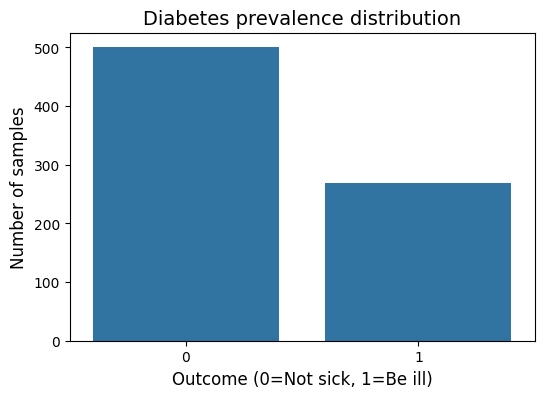

In [125]:
plt.figure(figsize=(6,4))
sns.countplot(x="Outcome",data=df)
plt.title("Diabetes prevalence distribution",fontsize=14)
plt.xlabel("Outcome (0=Not sick, 1=Be ill)",fontsize=12)
plt.ylabel("Number of samples",fontsize=12)
plt.show()

## Data Preprocessing
### Outlier handling
#### 0 values in medical features often indicate missing data in datasets, and I identified and processed these values by replacing 0 values that were clearly missing data with NaN
### Data cleaning and imputation
#### In order to fill in the missing values in the data set, we usually use the median replacement method. However, considering that there may be some differences in the medical characteristics of the affected and unaffected people, in order to avoid the influence of the possible differences on the prediction results, I solve the problem of missing medical characteristics by replacing the missing values in the medical characteristics of the corresponding population with the median of the corresponding medical characteristics of the affected population and the non-affected population respectively

In [127]:
invalid_zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

def group_median_imputation(df, target_column="Outcome"):
    df_clean = df.copy()
    for col in invalid_zero_features:
        df_clean[col] = df_clean[col].replace(0, np.nan)
    for col in invalid_zero_features:
        median_0 = df_clean[df_clean[target_column] == 0][col].median()
        median_1 = df_clean[df_clean[target_column] == 1][col].median()
        df_clean.loc[df_clean[target_column] == 0, col] = df_clean.loc[df_clean[target_column] == 0, col].fillna(median_0)
        df_clean.loc[df_clean[target_column] == 1, col] = df_clean.loc[df_clean[target_column] == 1, col].fillna(median_1)
    return df_clean

df_clean = group_median_imputation(df)

def create_preprocessor(target_column="Outcome"):
    numeric_features = [col for col in df.columns if col != target_column]
    preprocessor = ColumnTransformer(transformers=[("num", Pipeline(steps=[("scaler", StandardScaler())]), numeric_features)],remainder="passthrough")
    return preprocessor

preprocessor=create_preprocessor()

In [128]:
df_clean.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.677083      72.389323      29.089844  141.753906   
std       3.369578   30.464161      12.106039       8.890820   89.100847   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  102.500000   
50%       3.000000  117.000000      72.000000      28.000000  102.500000   
75%       6.000000  140.250000      80.000000      32.000000  169.500000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.434635                  0.471876   33.240885    0.348958  
std      6.880498                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.050000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

## Data visualization

### Multivariate joint distribution plot
#### Display the joint distribution of key features using pairplot

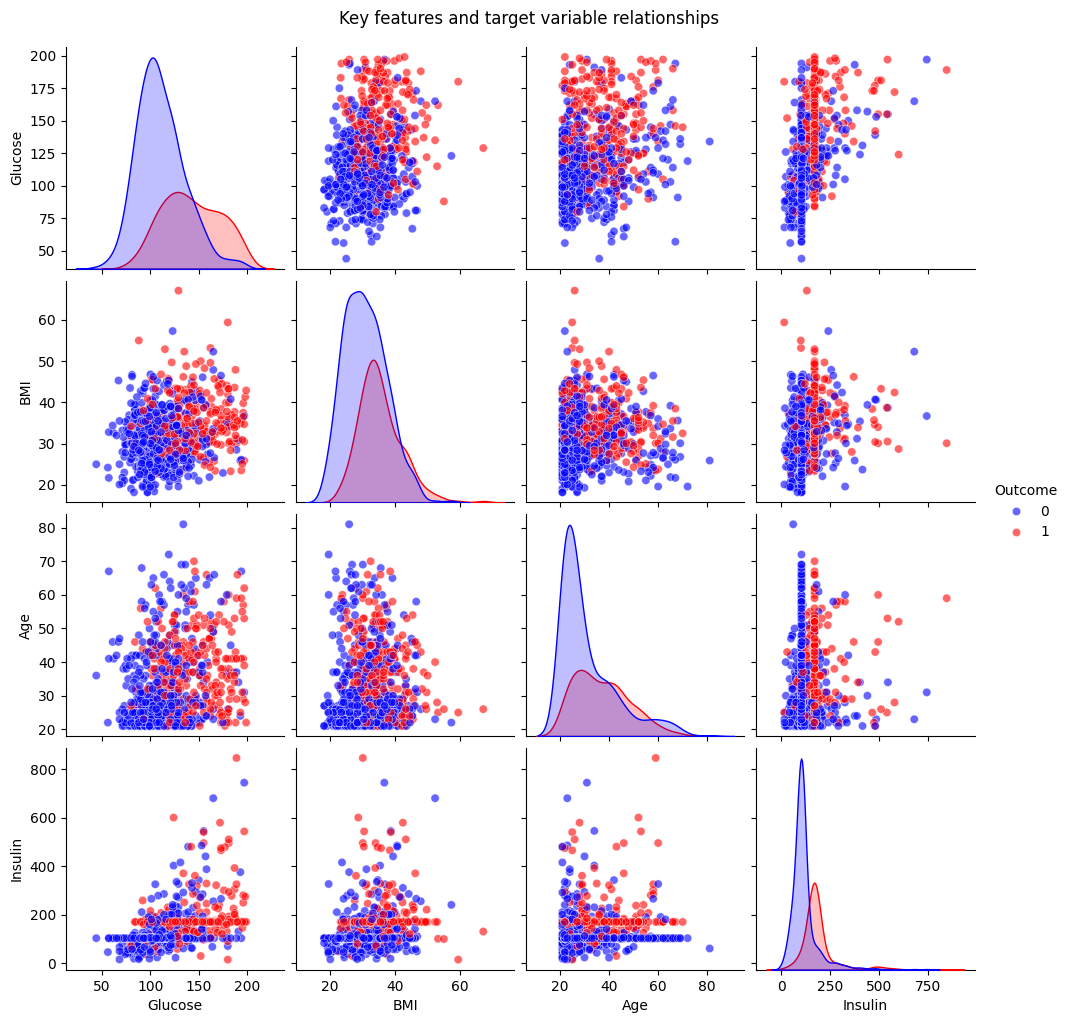

In [129]:
selected_features=["Glucose","BMI","Age","Insulin","Outcome"]
sns.pairplot(df_clean[selected_features], hue="Outcome",diag_kind="kde",plot_kws={"alpha":0.6}, palette={0:"blue", 1:"red"})
plt.suptitle("Key features and target variable relationships", y=1.02)
plt.show()

### Faceted histogram
#### Show the distribution of important features under different outcomes

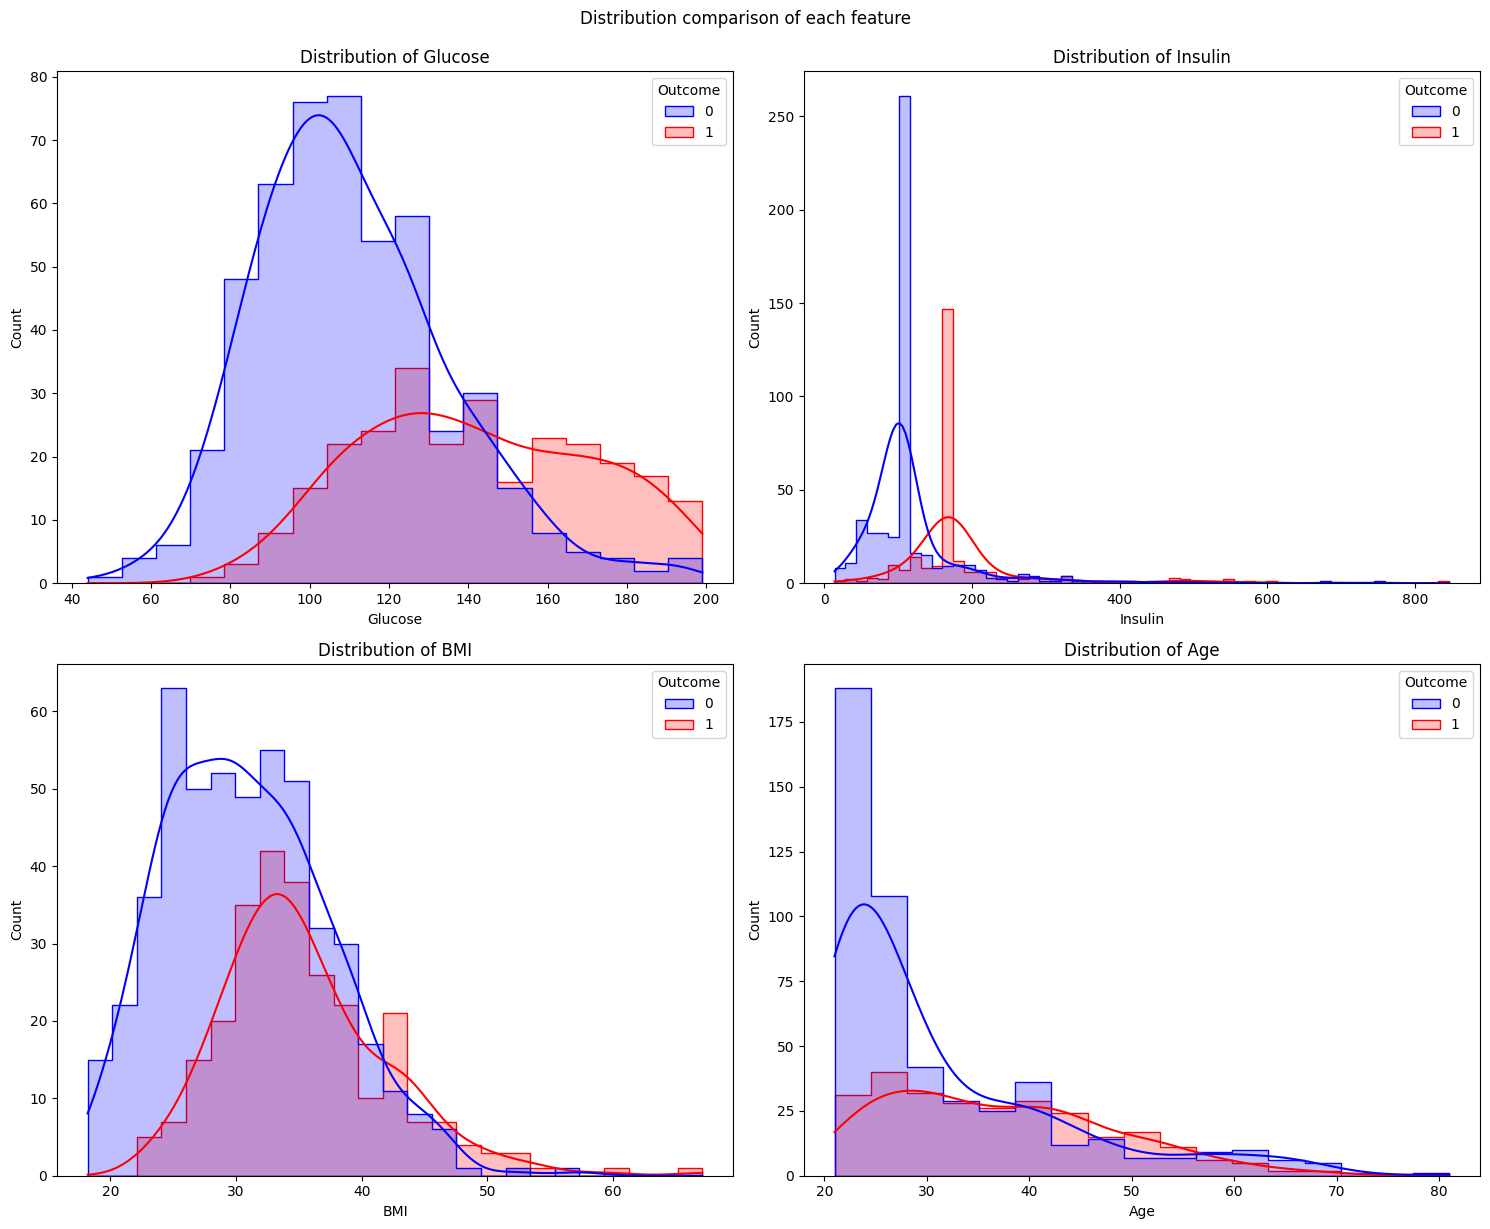

In [130]:
fig, axes=plt.subplots(2,2,figsize=(15,12))
features=["Glucose","Insulin","BMI","Age"]

for i, feature in enumerate(features):
    row,col=i//2, i%2
    sns.histplot(data=df_clean,x=feature,hue="Outcome",kde=True,ax=axes[row,col],element="step",palette={0:"blue",1:"red"})
    axes[row,col].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.suptitle("Distribution comparison of each feature", y=1.02)
plt.show()

### Scatter matrix plot
#### Shows the distribution of disease across conditions

In [131]:
fig = px.scatter_matrix(df_clean,
                        dimensions=["Glucose","BMI","Age","Insulin"],
                        color="Outcome",
                        color_discrete_map={0:"blue",1:"red"},
                        title="Scatter matrix plot between features",
                        width=1000,height=800)
fig.update_traces(diagonal_visible=False)
fig.show()

### Heat map
#### Show the correlation between different features

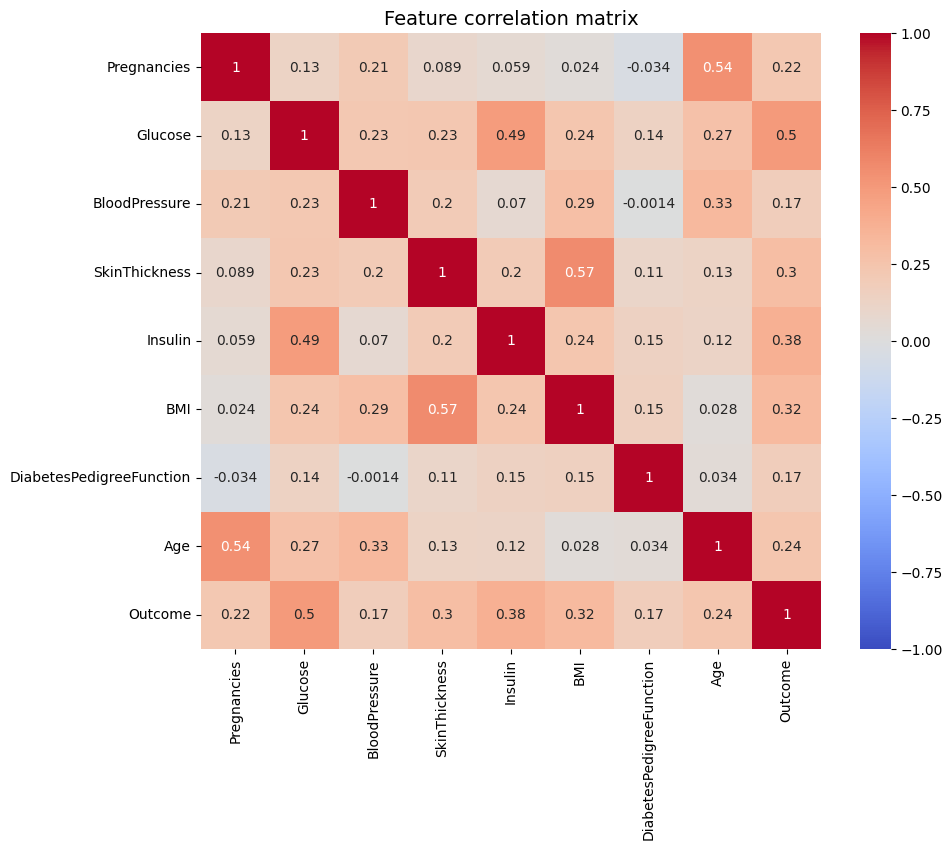

In [132]:
corr=df_clean.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap="coolwarm",vmin=-1,vmax=1)
plt.title("Feature correlation matrix",fontsize=14)
plt.show()

### Boxplots comparing feature distributions
#### The distribution differences of key features (Glucose, BMI, Age) were compared between the affected and non-affected groups

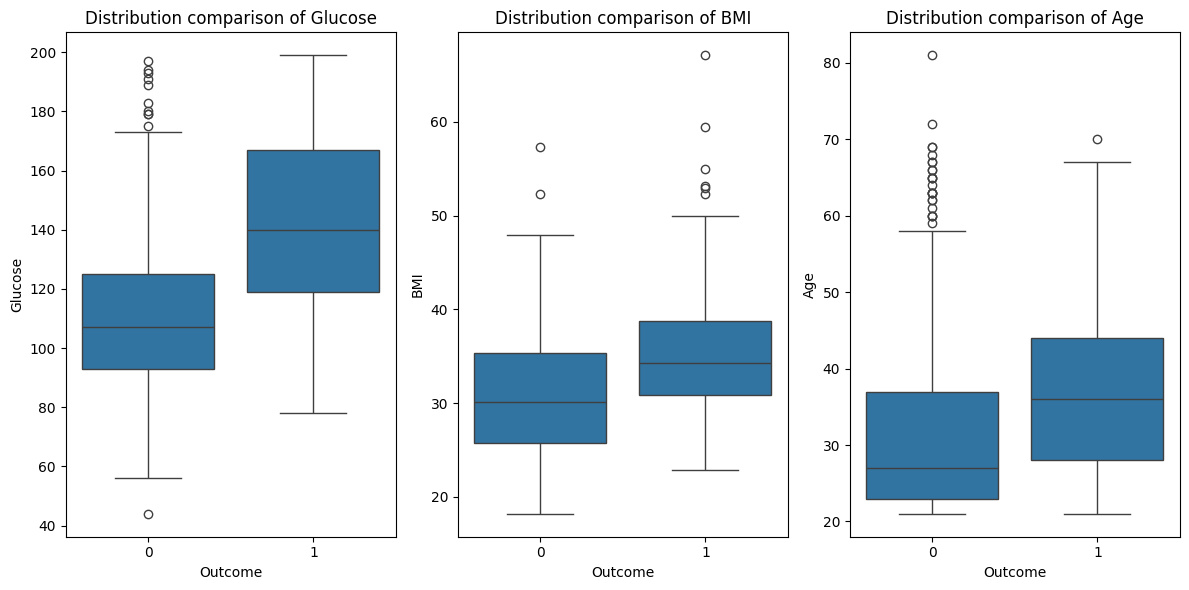

In [133]:
features=["Glucose","BMI","Age"]
plt.figure(figsize=(12,6))
for i,feature in enumerate(features):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='Outcome',y=feature,data=df_clean)
    plt.title(f"Distribution comparison of {feature}",fontsize=12)
plt.tight_layout()
plt.show()

### Kernel Density Estimation (KDE) plot
#### It shows the probability density distribution of continuous features, and clearly compares the overlap/separation between the distributions of the two classes

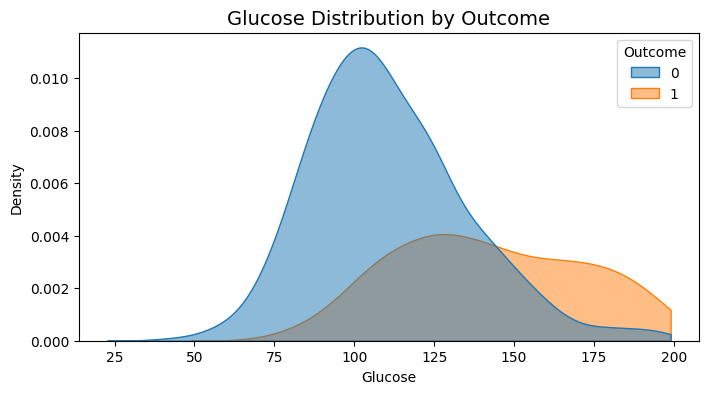

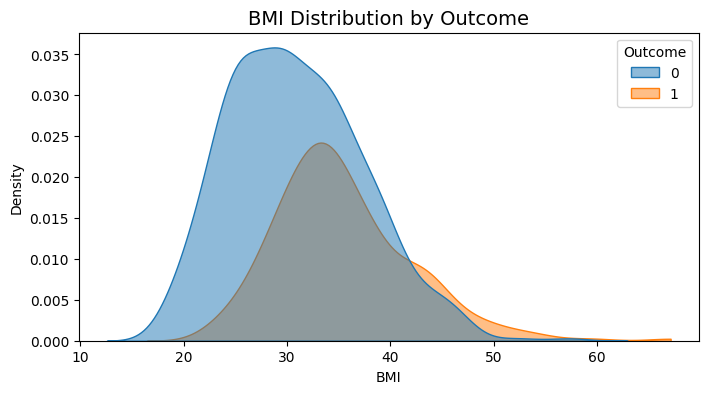

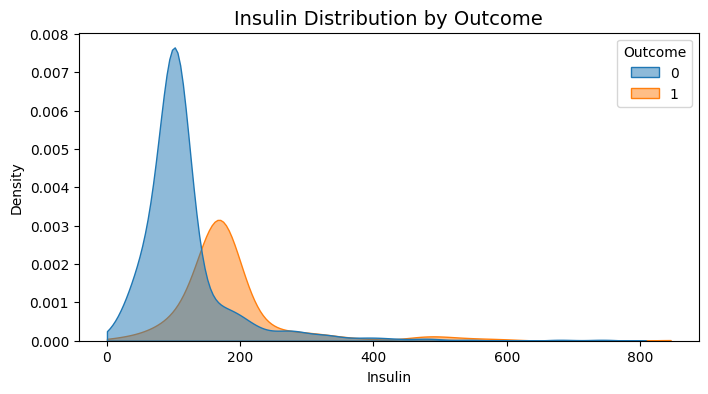

In [134]:
columns_to_visualize = ["Glucose", "BMI", "Insulin"]

for feature in columns_to_visualize:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_clean,x=feature,hue="Outcome",fill=True,alpha=0.5,clip=(df[feature].min(),df[feature].max()))
    
    plt.title(f"{feature} Distribution by Outcome", fontsize=14)
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.show()

## Model development
#### Three different models are developed, which are logistic regression model, random forest model, support vector machine model

### Data preparation
#### The training set and test set are divided, and feature scaling is performed

In [ ]:
X=df_clean.drop("Outcome", axis=1)
y=df_clean["Outcome"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

### Training a logistic regression model

In [135]:
logreg_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("classifier",LogisticRegression(max_iter=1000))])
logreg_param_grid = {
    'classifier__C':[0.001,0.01,0.1,1,10,100],
    'classifier__penalty':['l1','l2'],
    'classifier__solver':['liblinear']
}
logreg_grid=GridSearchCV(logreg_pipeline,logreg_param_grid,cv=5,scoring='roc_auc',n_jobs=-1)
logreg_grid.fit(X_train,y_train)
best_logreg_model=logreg_grid.best_estimator_

### Training random forests

In [136]:
rf_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("classifier",RandomForestClassifier(random_state=42))])
param_grid={
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}
grid_search=GridSearchCV(rf_pipeline,param_grid,cv=5,scoring="roc_auc",n_jobs=-1)
grid_search.fit(X_train,y_train)
best_rf_model=grid_search.best_estimator_

### Training the support vector machine model

In [137]:
svm_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("classifier",SVC(random_state=42))])
svm_param_grid={
    "classifier__kernel":["linear","rbf"],
    "classifier__C":[0.1,1,10],
    "classifier__gamma":["scale","auto"]
}
grid_search_svm=GridSearchCV(svm_pipeline,svm_param_grid,cv=5,scoring="roc_auc",n_jobs=-1)
grid_search_svm.fit(X_train,y_train)
best_svm_model=grid_search_svm.best_estimator_

## Model evaluation
#### Evaluate the performance difference between different models

### ROC curve
#### The AUC area quantifies the overall discrimination of the model (0.5= random guess, 1= perfect prediction), and supports multi-model comparison (the closer the curve is to the top-left corner, the better).

In [138]:
def evaluate_model(model,X_test,y_test,model_name):
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:, 1]if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    print(f"Evaluation result for {model_name}:")
    print(f"Accuracy score:{accuracy_score(y_test,y_pred):.4f}")
    print(f"Precision score:{precision_score(y_test,y_pred):.4f}")
    print(f"Recall rate:{recall_score(y_test,y_pred):.4f}")
    print(f"F1 score:{f1_score(y_test,y_pred):.4f}")
    print(f"ROC-AUC:{roc_auc_score(y_test,y_prob):.4f}")
    
    cm=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True,fmt="d",cmap="Blues",xticklabels=["Not sick","Be ill"], yticklabels=["Not sick","Be ill"])
    plt.xlabel("Predicted value",fontsize=12)
    plt.ylabel("True value",fontsize=12)
    plt.title(f"Confusion matrix for {model_name}", fontsize=14)
    plt.show()
    
    fpr,tpr,thresholds=roc_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr,color="darkorange",lw=2,label=f"ROC curve(AUC={roc_auc_score(y_test,y_prob):.2f})")
    plt.plot([0,1],[0,1],color="navy",lw=2,linestyle="--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("FPR",fontsize=12)
    plt.ylabel("TPR",fontsize=12)
    plt.title(f'{model_name} ROC curve',fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

Evaluation result for Logistic regression:
Accuracy score:0.7208
Precision score:0.6000
Recall rate:0.6111
F1 score:0.6055
ROC-AUC:0.8248


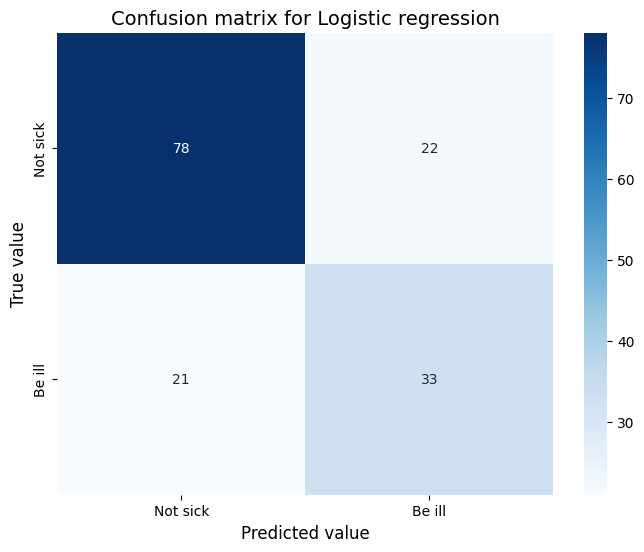

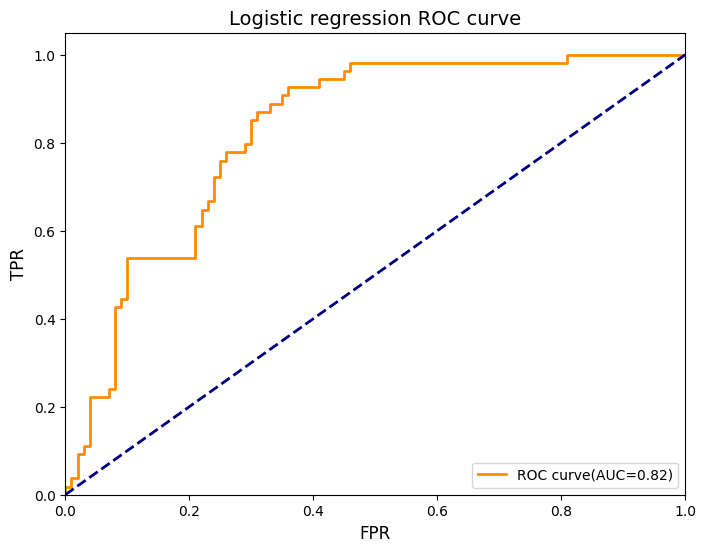

In [139]:
evaluate_model(best_logreg_model,X_test,y_test,"Logistic regression")

Evaluation result for Random forest:
Accuracy score:0.8571
Precision score:0.8077
Recall rate:0.7778
F1 score:0.7925
ROC-AUC:0.9446


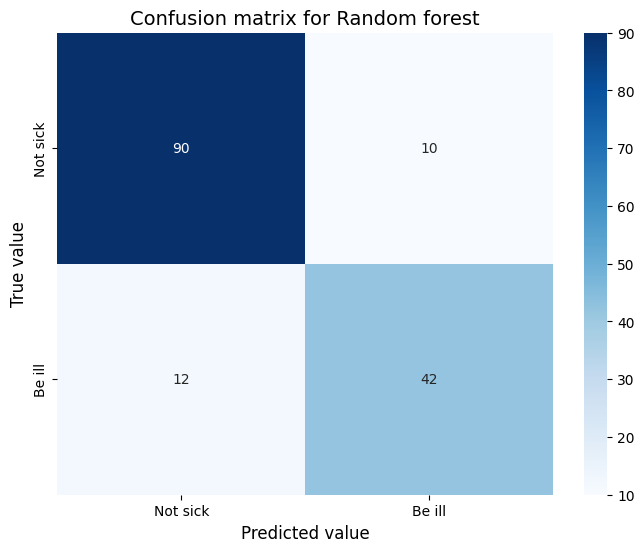

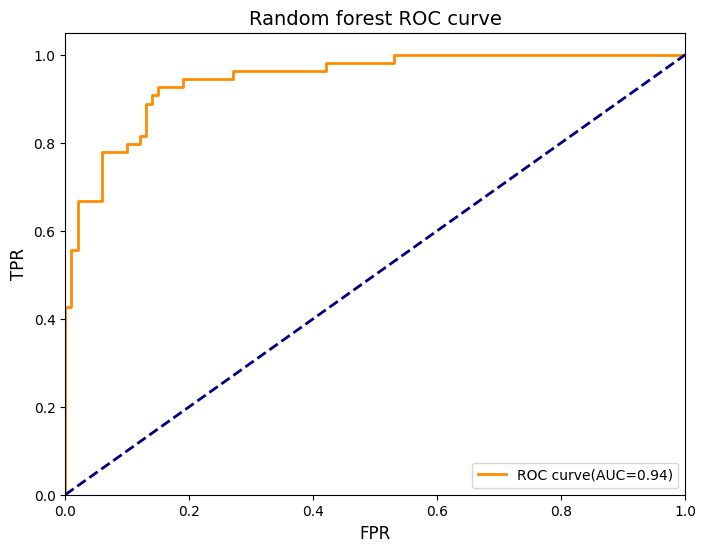

In [140]:
evaluate_model(best_rf_model,X_test,y_test,"Random forest")

Evaluation result for Support Vector Machine:
Accuracy score:0.8377
Precision score:0.7636
Recall rate:0.7778
F1 score:0.7706
ROC-AUC:0.8974


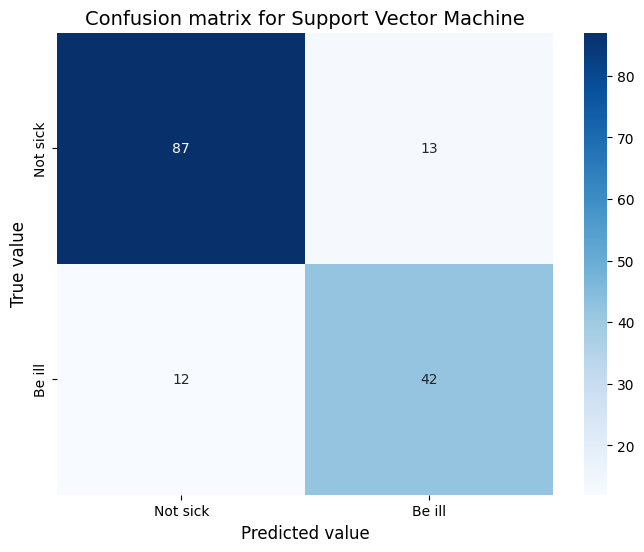

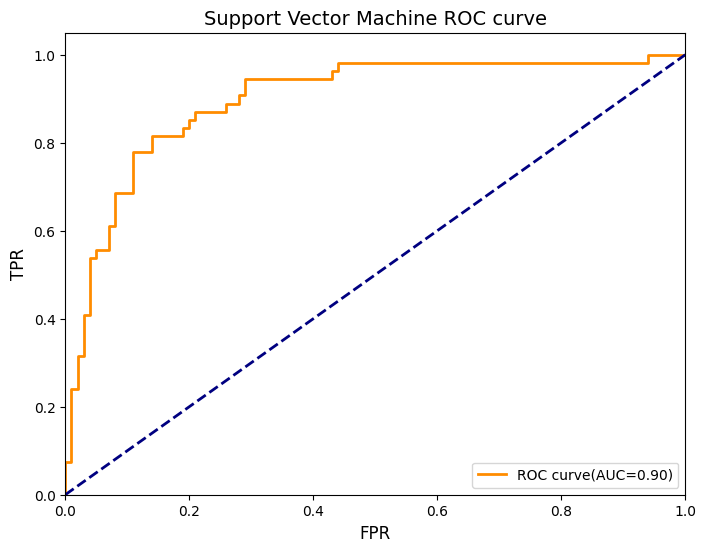

In [141]:
evaluate_model(best_svm_model,X_test, y_test,"Support Vector Machine")

### Learn which features have the most impact on the prediction

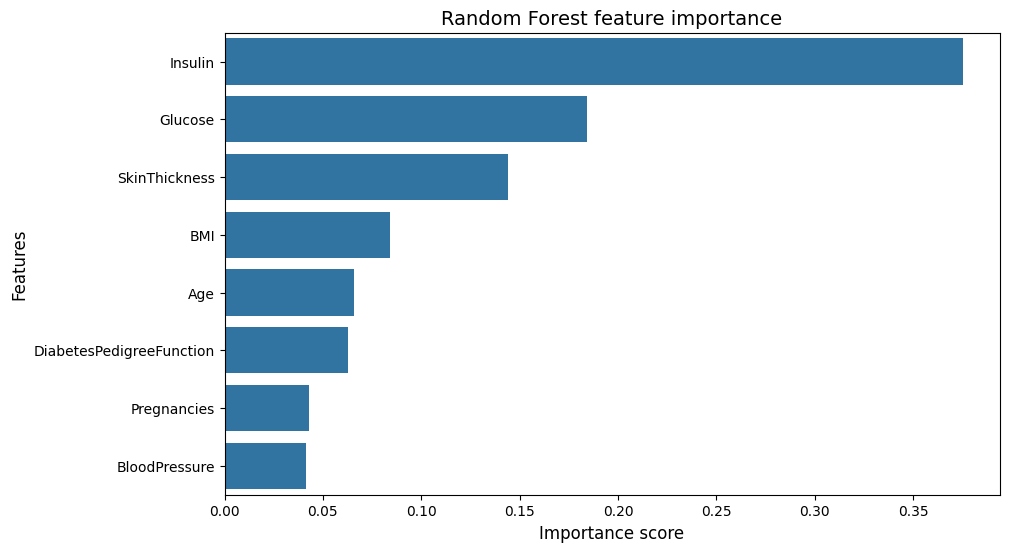

In [142]:
if hasattr(best_rf_model,"named_steps") and "classifier" in best_rf_model.named_steps:
    rf_classifier=best_rf_model.named_steps["classifier"]
    feature_names=X.columns.tolist()
    feature_importance=rf_classifier.feature_importances_
    importance_df=pd.DataFrame({
        "Features":feature_names,
        "Importance score":feature_importance
    }).sort_values(by="Importance score",ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance score",y="Features",data=importance_df)
    plt.title("Random Forest feature importance", fontsize=14)
    plt.xlabel("Importance score",fontsize=12)
    plt.ylabel("Features",fontsize=12)
    plt.show()

### Compare the performance of different models

In [143]:
models = {
    "Logistic Regression": best_logreg_model,
    "Random Forest": best_rf_model,
    "Support Vector Machine": best_svm_model
}

metrics = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    metrics.append({
        "Model": name,
        "Accuracy": f"{accuracy_score(y_test, y_pred):.4f}",
        "ROC-AUC": f"{roc_auc_score(y_test, y_prob):.4f}"
    })

print("Multi-Model Performance Summary")
print(pd.DataFrame(metrics).set_index("Model"))

Multi-Model Performance Summary
                       Accuracy ROC-AUC
Model                                  
Logistic Regression      0.7208  0.8248
Random Forest            0.8571  0.9446
Support Vector Machine   0.8377  0.8974


### Learning curve
#### Analyze model performance on the training and validation sets as the amount of data increases, and diagnose underfitting (low on both curves) or overfitting (high training score but low validation score).

In [144]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of training samples", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc', random_state=42)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

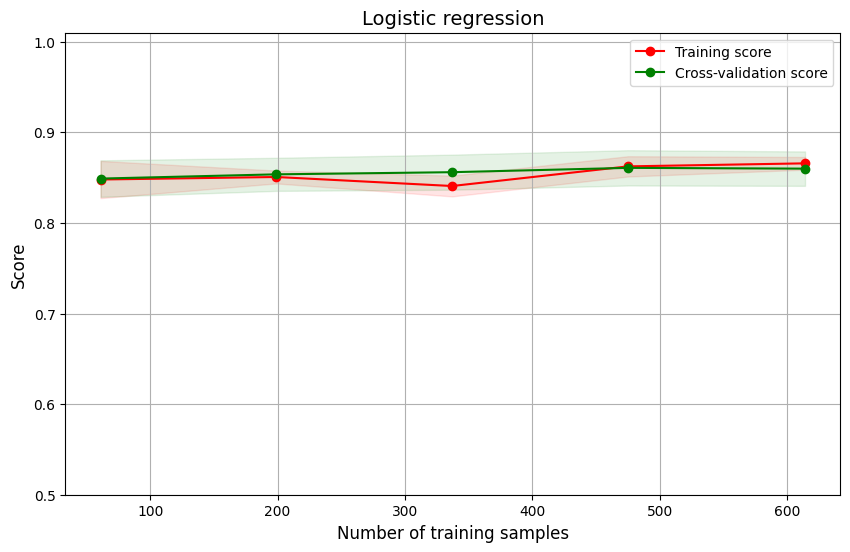

In [145]:
plt = plot_learning_curve(best_logreg_model, "Logistic regression", X, y, ylim=(0.5, 1.01))
plt.show()

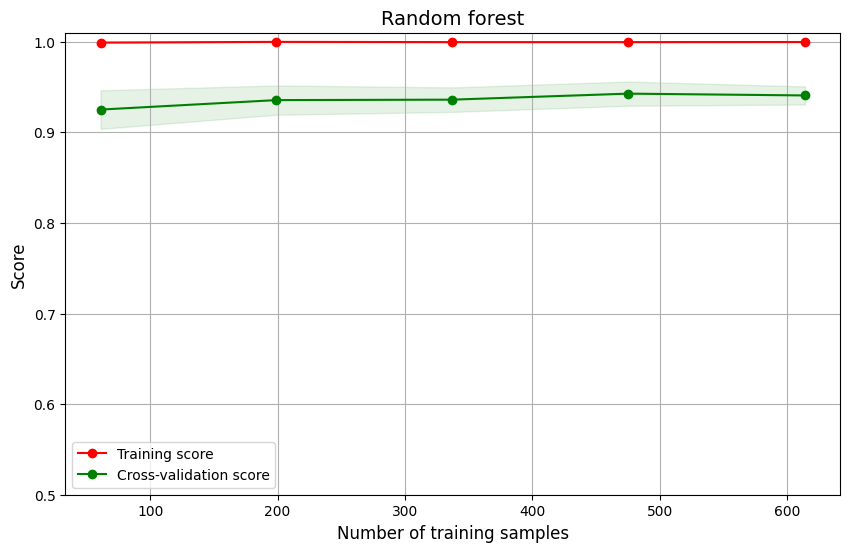

In [146]:
plt = plot_learning_curve(best_rf_model, "Random forest", X, y, ylim=(0.5, 1.01))
plt.show()

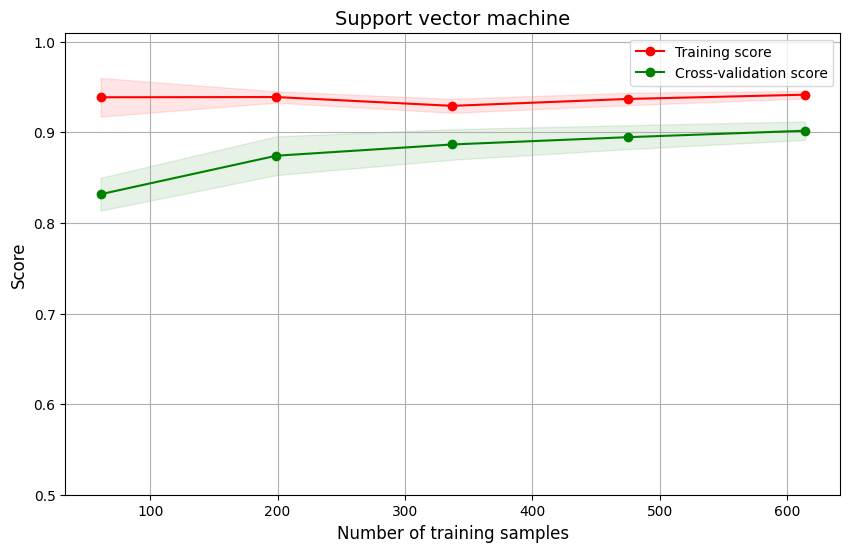

In [147]:
plt = plot_learning_curve(best_svm_model, "Support vector machine", X, y, ylim=(0.5, 1.01))
plt.show()

## Saving the model
#### Save the trained model to the destination folder

In [151]:
model_save_path = "./saved_models/"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

for model_name,model in models.items():
    model_filename=f"{model_save_path}/{model_name.replace(" ","_").lower()}_model.pkl"
    joblib.dump(model, model_filename)
    print(f"{model_name} model saved to{model_filename}")

Logistic Regression model saved to ./saved_models//logistic_regression_model.pkl
Random Forest model saved to ./saved_models//random_forest_model.pkl
Support Vector Machine model saved to ./saved_models//support_vector_machine_model.pkl
